Your Goal: Predict the price of backpacks given various attributes.

Evaluation
Root Mean Squared Error (RMSE)
Submissions are scored on the root mean squared error. RMSE is defined as:

RMSE=(1N∑i=1N(yi−yˆi)2)12

where yˆi
 is the predicted value and yi
 is the original value for each instance i
.

Submission File
For each id in the test set, you must predict the Price of the backpack. The file should contain a header and have the following format:

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
train_df=pd.read_csv('train.csv')
test_df= pd.read_csv('test.csv')

Data exploration

In [48]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [4]:
train_df.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


In [5]:
train_df.shape

(300000, 11)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [7]:
train_df.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [19]:
train_df.isnull().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

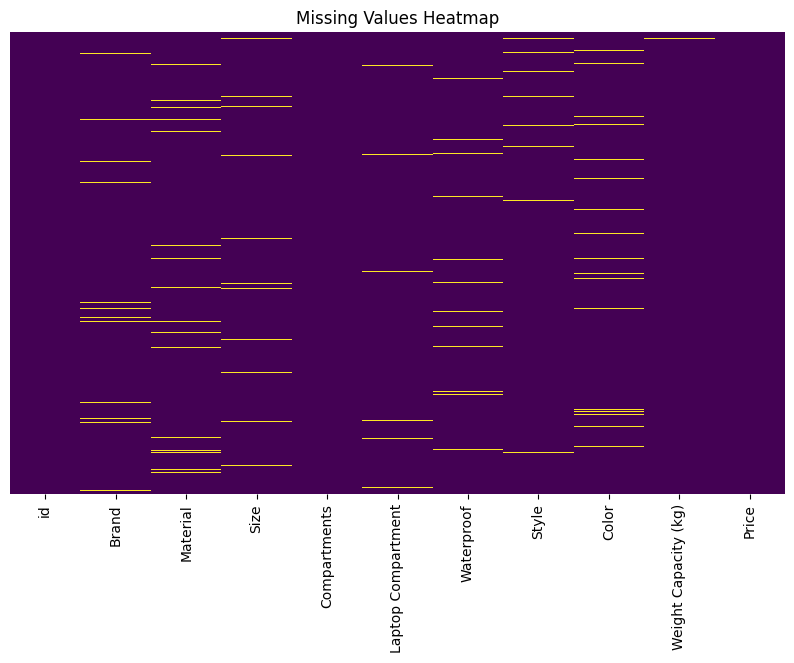

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

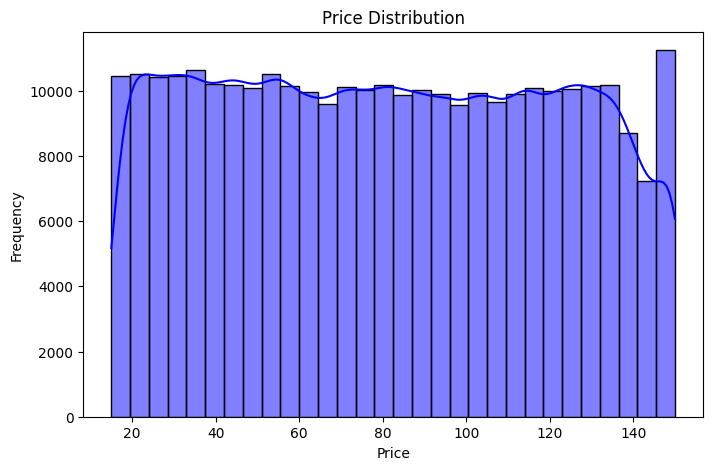

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df["Price"], bins=30, kde=True, color="blue")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

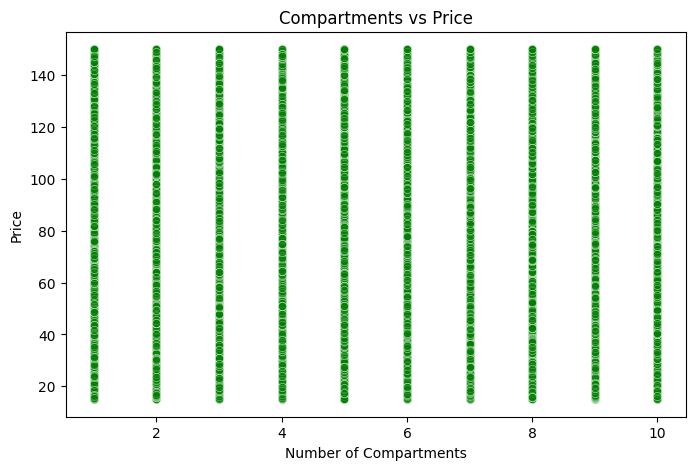

In [49]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=train_df["Compartments"], y=train_df["Price"], alpha=0.6, color="green")
plt.title("Compartments vs Price")
plt.xlabel("Number of Compartments")
plt.ylabel("Price")
plt.show()

C:\Users\Vidushi\AppData\Local\Temp\ipykernel_24732\1311968564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df["Brand"].value_counts().index[:10],


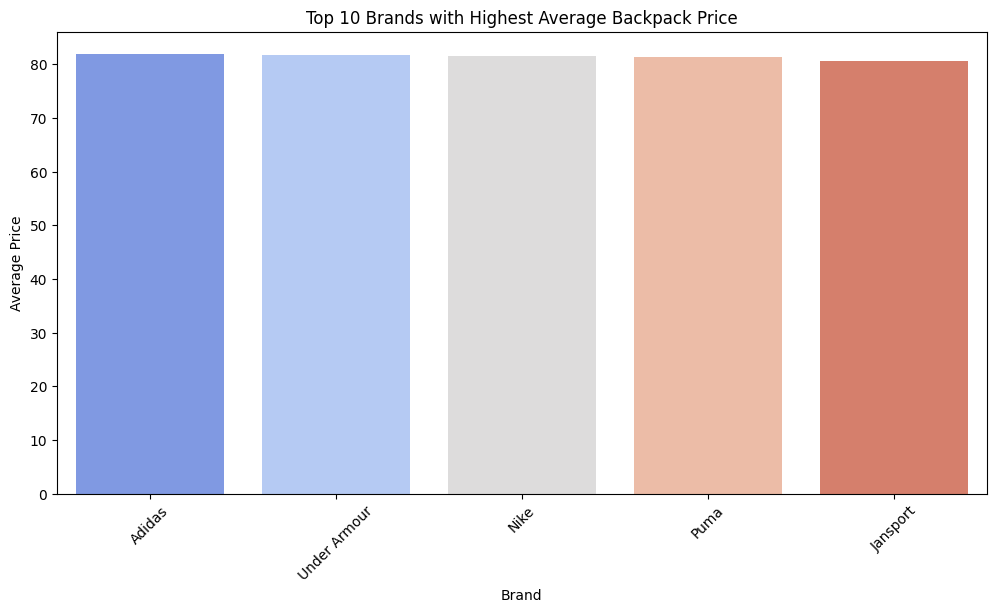

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x=train_df["Brand"].value_counts().index[:10], 
            y=train_df.groupby("Brand")["Price"].mean().sort_values(ascending=False)[:10], 
            palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Brands with Highest Average Backpack Price")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.show()

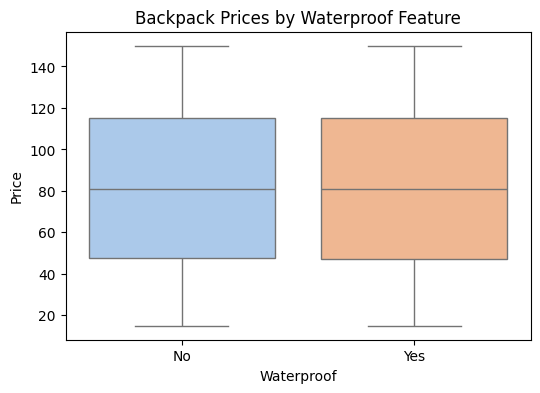

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Waterproof", y="Price", data=train_df, hue="Waterproof", palette="pastel", legend=False)
plt.title("Backpack Prices by Waterproof Feature")
plt.xlabel("Waterproof")
plt.ylabel("Price")
plt.show()

Data preprocessing

In [20]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [77]:
def target_encode(train_df, test_df, cat_columns, target_column):
    encoding_dict = {}  # Store mappings
    
    for col in cat_columns:
        # Compute mean encoding from training data
        encoding = train_df.groupby(col)[target_column].mean()
        encoding_dict[col] = encoding  # Save encoding for test data
        
        # Apply encoding to training data
        train_df[col] = train_df[col].map(encoding)

    # Apply saved encoding to test data
    for col in cat_columns:
        test_df[col] = test_df[col].map(encoding_dict[col])

    return train_df, test_df  # Return both transformed DataFrames

In [78]:
cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

train_df, test_df = target_encode(train_df, test_df, cat_columns, 'Price')

In [55]:
train_df.isnull().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [56]:
test_df.shape

(200000, 10)

In [79]:
train_df['Weight Capacity (kg)'] = train_df['Weight Capacity (kg)'].fillna(train_df['Weight Capacity (kg)'].mean()) 

categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

for col in categorical_columns:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [80]:
test_df['Weight Capacity (kg)'] = test_df['Weight Capacity (kg)'].fillna(test_df['Weight Capacity (kg)'].mean()) 

categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

for col in categorical_columns:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [81]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,81.791276,80.437883,81.343418,7.0,81.463842,81.572050,81.374865,80.513439,11.611723,112.15875
1,1,81.791276,82.106511,81.424674,10.0,81.463842,81.403489,81.410925,82.381308,27.078537,68.88056
2,2,81.976311,80.437883,81.424674,2.0,81.463842,81.572050,81.410925,81.011644,16.643760,39.17320
3,3,81.319209,81.024760,81.424674,8.0,81.463842,81.572050,81.410925,82.381308,12.937220,80.60793
4,4,80.631060,82.106511,81.343418,1.0,81.463842,81.403489,81.410925,82.381308,17.749338,86.02312


In [82]:
test_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,81.448607,80.437883,81.424674,2.0,81.464702,81.572050,81.374865,82.381308,20.671147
1,300001,81.319209,82.106511,81.343418,7.0,81.464702,81.403489,81.402513,82.381308,13.564105
2,300002,80.631060,82.106511,81.651446,9.0,81.464702,81.403489,81.410925,82.006994,11.809799
3,300003,80.631060,81.024760,81.651446,1.0,81.463842,81.572050,81.410925,82.381308,18.477036
4,300004,80.631060,81.024760,81.651446,2.0,81.463842,81.403489,81.374865,80.513439,9.907953


In [83]:
X= train_df.drop(columns=['Price'])
y= train_df.Price

In [84]:
X.shape

(300000, 10)

In [85]:
test_df.shape

(200000, 10)

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),  # Corrected input shape
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [87]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=150,       
    learning_rate=0.05,    
    max_depth=5,           
    subsample=0.8,         
    min_samples_split=4,   
    min_samples_leaf=2,    
    random_state=42
)

model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=150,
                          random_state=42, subsample=0.8)

In [88]:
pred=model.predict(X_test)

In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

res= mean_absolute_error(pred, y_test)
res1= np.sqrt(mean_squared_error(pred, y_test))
print(res)
print(res1)

33.642916012266866
38.91910061143074


In [90]:
predictions= model.predict(test_df)

C:\Users\Vidushi\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


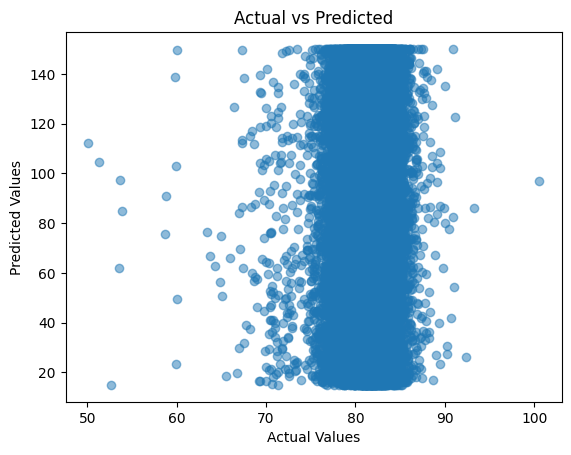

In [93]:
import matplotlib.pyplot as plt

plt.scatter(pred, y_test, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


In [97]:
submission = pd.DataFrame({'id': test_df['id'], 'prediction': predictions})

submission.to_csv('submission.csv', index=False)